This code is useful in data loading, visualization and exploration. You are free to modify the code. The code has dependecy on Pytorch Lightning data module. However, you may use Pytorch as well.

**Introduction to Dataset**

The data has a total of 10 classes with 40 samples each. Make sure while working with the data, **esc10=True**. In the assignment, you are required to perform 4-fold validation. This dataset has been already divided into 5-folds. The column 'fold' in the metafile denotes the sample in a particular fold. Moreover, first folds is considered for test, rest for 4-fold validation.

In [ ]:
# DL Assignment 2
# Authors: Kopal Rastogi, Ishan Mishra
# Keywords: None
# Assumptions: None

In [ ]:
# Installing the requirements
print('Installing Requirements... ',end='')
!pip install lightning
!pip install wandb
print('Done')

Installing Requirements... Requirement already satisfied: lightning in /usr/local/lib/python3.10/dist-packages (2.2.0.post0)
Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing the libraries**

In [ ]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
print('Done')

Importing Libraries... Done


In [ ]:
# # Download data
# print('Downlading data... ', end='')
# # Your code here
# print('Done')

In [ ]:
# # Extract data
# with zipfile.ZipFile("/content/drive/MyDrive/deep learning 2/Archive (2).zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/deep learning 2")

# **Uploading the dataset and reshaping it in convnient form**

In [ ]:
# Loading dataset
path = Path('/content/drive/MyDrive/deep learning 2')
df = pd.read_csv('/content/drive/MyDrive/deep learning 2/meta/esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


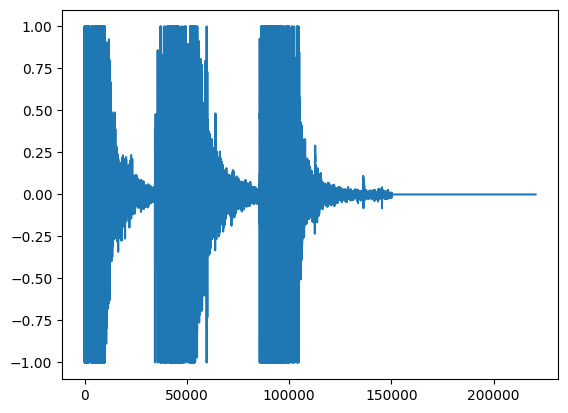

In [ ]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[0])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [ ]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        examples = torch.stack(examples)
        examples=examples.reshape(examples.size(0),1,-1)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [ ]:
# Data Setup
test_samp = 1
valid_samp = 2 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
batch_size = 32 # Free to change
num_workers = 8 # Free to change
custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=valid_samp,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )

custom_data_module.setup()


100%|██████████| 80/80 [00:00<00:00, 4134.15it/s]


In [ ]:
# Data Exploration
print('Class Label: ', custom_data_module.training_dataset[0][1])  # this prints the class label
print('Shape of data sample tensor: ', custom_data_module.training_dataset[0][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)


Class Label:  2
Shape of data sample tensor:  torch.Size([9, 1, 16000])


In [ ]:
# Dataloader(s)
x = next(iter(custom_data_module.train_dataloader()))
y = next(iter(custom_data_module.val_dataloader()))
z = next(iter(custom_data_module.test_dataloader()))
print('Train Dataloader:')
print(x)
print('Validation Dataloader:')
print(y)
print('Test Dataloader:')
print(z)
print(x[0].shape)
print(x[1].shape)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Dataloader:
[tensor([[[-6.1283e-04, -1.1775e-03, -1.0586e-03,  ...,  1.2037e-02,
           1.1583e-02,  1.2952e-02]],

        [[-1.1695e-03, -1.9361e-03, -1.7424e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[ 6.0976e-05,  1.0087e-04,  4.8497e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-1.2567e-03, -2.4440e-03, -2.7032e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 4.8190e-02,  4.1202e-02, -2.9378e-02,  ...,  6.8517e-02,
           6.5081e-02,  7.6646e-04]]]), tensor([4, 9, 1, 3, 5, 0, 2, 3, 0, 6, 6, 5, 3, 8, 5, 6, 9, 4, 0, 3, 5, 8, 9, 3,
        1, 5, 1, 6, 5, 4, 4, 8])]
Validation Dataloader:
[tensor([[[-4.1812e-05, -9.4571e-05, -2.7154e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-9.2098e-02, -2.8477e-02,  1.7923e-02,  ...,  9.4242e-02,
           

# **Describing my CNN Architecture for multi-class classification containing 4 convolution layer**

In [ ]:
import torch
import torch.nn as nn

num_classes = 10

class Conv_Archi(nn.Module):
    def __init__(self):
        super(Conv_Archi , self).__init__()

        # Define 1D convolution layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=11,  padding=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=14, padding=7)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=10,  padding=5)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11,  padding=5)

        # Define max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=5)

        # Define global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool1d(20)

        # Calculate the output size of the last convolutional layer
        # Assuming input size of 144000
        self.last_conv_out_channels = 64


        # Define fully-connected layer for classification
        self.fc = nn.Linear(self.last_conv_out_channels*20, num_classes)

        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x=self.pool(x)

        # Global average pooling
        x = self.global_pool(x)

        # Flatten the output for fully-connected layer
        x = x.view(x.size(0), -1)

        # Forward pass through fully-connected layer
        x = self.fc(x)
        return x

# Initialize the network
model = Conv_Archi()

# Print the model architecture
print(model)


Conv_Archi(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv2): Conv1d(8, 16, kernel_size=(14,), stride=(1,), padding=(7,))
  (conv3): Conv1d(16, 32, kernel_size=(10,), stride=(1,), padding=(5,))
  (conv4): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=20)
  (fc): Linear(in_features=1280, out_features=10, bias=True)
  (relu): ReLU()
)


# **Importing Wandb library and initializing it**

In [ ]:
import wandb
wandb.init(project='DL2' , entity='harsh6387')

Training Accuracy for CNN Architecture,▁▂▄▄▆▆▆▆▇▇▇▇▇▇▇▇██████▇▇█████▃▄▅▁▃▄▅▅▆▆▆
Epoch,▁▂▃▅▇█▂▃▅▇▁▃▄▅▇▁▃▄▅▇▁▃▄▅▇▁▃▄▅▇▁▃▅▆▇▁▃▅▆█
Train Accuracy,▁▁▂▃▃▄▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇██▇███
Train Accuracy of transformer model,▁▁▁▃▄▄▄▄▅▅▅▅▆▇▇▇▇▇▇▇██████▇███
Train Accuracy of transformer model 2,▁▁▃▃▃▃▃▄▃▃▄▃▃▃▄▄▄▄▅▅▅▅▅▅▆▅▅▆▆▇▇█▇▇▇▇▇███
Train Accuracy of transformer model 3,▁▂▃▃▄▅▅▅▅▆▆▆▆▇▆▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇████▇▇▇▇█
"Train Accuracy transformer model 2,1",▇▁▂▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇██▇█████
Train Loss,██▇▇▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss of Transformer model,█▇▇▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Train Loss of Transformer model 2,█▇▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▃▂▃▃▂▂▂▂▁▁▁▂▂▂▁▁▁
Train Loss of Transformer model 3,█▇▆▅▄▄▄▄▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁


# **Training my CNN Architecture model And Printing the accuracy and loss for 100 Epochs and ploting the graph on wandb**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim



# Assuming you have a DataLoader named train_loader for your training dataset

# Define your model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Train the model
train_loader=custom_data_module.train_dataloader()
num_epochs = 30  # Adjust number of epochs as needed
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the device (e.g., GPU)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)


        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track training statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Print epoch statistics
    epoch_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
    wandb.log({'Training loss for CNN Architecture':epoch_loss, ' Training Accuracy for CNN Architecture': accuracy})

print('Finished Training')


Epoch [1/30], Loss: 2.3066, Accuracy: 0.0958
Epoch [2/30], Loss: 2.2960, Accuracy: 0.1375
Epoch [3/30], Loss: 2.2529, Accuracy: 0.1667
Epoch [4/30], Loss: 2.1249, Accuracy: 0.3083
Epoch [5/30], Loss: 1.9451, Accuracy: 0.3792
Epoch [6/30], Loss: 1.7752, Accuracy: 0.4667
Epoch [7/30], Loss: 1.5902, Accuracy: 0.4250
Epoch [8/30], Loss: 1.5557, Accuracy: 0.4458
Epoch [9/30], Loss: 1.4820, Accuracy: 0.4875
Epoch [10/30], Loss: 1.3954, Accuracy: 0.5292
Epoch [11/30], Loss: 1.3017, Accuracy: 0.5000
Epoch [12/30], Loss: 1.3596, Accuracy: 0.5375
Epoch [13/30], Loss: 1.3023, Accuracy: 0.5333
Epoch [14/30], Loss: 1.2721, Accuracy: 0.5083
Epoch [15/30], Loss: 1.1549, Accuracy: 0.5833
Epoch [16/30], Loss: 1.1146, Accuracy: 0.5458
Epoch [17/30], Loss: 1.0738, Accuracy: 0.6292
Epoch [18/30], Loss: 1.0153, Accuracy: 0.6458
Epoch [19/30], Loss: 1.0070, Accuracy: 0.6458
Epoch [20/30], Loss: 0.9728, Accuracy: 0.6583
Epoch [21/30], Loss: 0.9486, Accuracy: 0.6583
Epoch [22/30], Loss: 0.8918, Accuracy: 0.68

# **Calculating the Validation Accuracy and validation loss**

In [ ]:
val_load=custom_data_module.val_dataloader()
model.eval()
val_loss=0.0
correct_val_pre=0
total_val_samp=0

with torch.no_grad():
  for val_in, val_lab in val_load:
    val_outputs=model(val_in)
    valdi_loss=criterion(val_outputs, val_lab)
    val_loss+=valdi_loss.item()*val_in.size(0)

    _, predict=torch.max(val_outputs,1)
    correct_val_pre+=(predict==val_lab).sum().item()
    total_val_samp+=val_lab.size(0)

avg_val_loss=val_loss/total_val_samp
val_accu=correct_val_pre/total_val_samp

print(f"validation loss:{avg_val_loss:.4f}, validation accuracy:{val_accu:.4f}")


validation loss:1.4496, validation accuracy:0.5750


In [ ]:
# k=4
# dataset_size=len(custom_data_module.dataset)
# fold_size=dataset_size//k


# **Testing the model of CNN Architecture**

In [ ]:
test_loader = custom_data_module.test_dataloader()
model.eval()
test_loss = 0.0
correct_test_pred = 0
total_test_samples = 0
predictions = []
all_labs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, predicted = torch.max(test_outputs, 1)
        correct_test_pred += (predicted == test_labels).sum().item()
        total_test_samples += test_labels.size(0)

        # Collect predictions and ground truth labels
        predictions.extend(predicted.tolist())
        all_labs.extend(test_labels.tolist())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test_samples
test_accuracy = correct_test_pred / total_test_samples

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.2490, Test Accuracy: 0.5125


# **Plotting the confusion matrix , calculating the f1 score for cnn architecture**


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.46      0.75      0.57         8
           2       0.33      0.38      0.35         8
           3       0.60      0.38      0.46         8
           4       0.80      0.50      0.62         8
           5       0.50      0.12      0.20         8
           6       0.38      0.75      0.50         8
           7       0.75      0.75      0.75         8
           8       0.33      0.38      0.35         8
           9       0.80      0.50      0.62         8

    accuracy                           0.51        80
   macro avg       0.56      0.51      0.50        80
weighted avg       0.56      0.51      0.50        80

F1-score: 0.5045


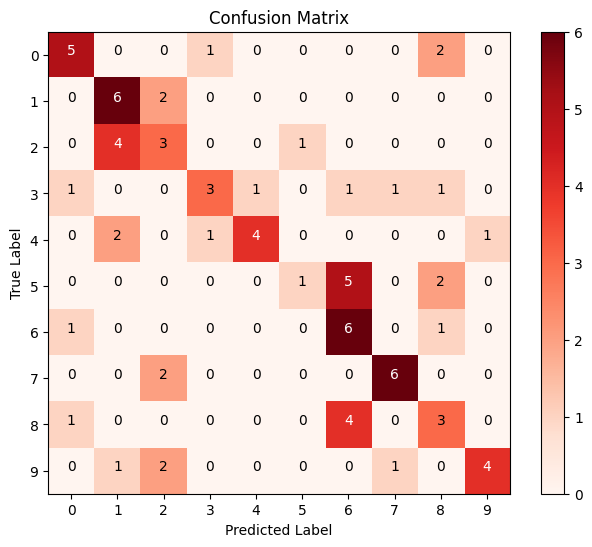

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
conf_matrix = confusion_matrix(all_labs, predictions)
class_report = classification_report(all_labs, predictions)


print("\nClassification Report:")
print(class_report)
f = f1_score(all_labs, predictions, average='weighted')
print(f'F1-score: {f:.4f}')


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Reds')

# Display the values inside the matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))
plt.show()

# **Report of total trainable and non trainable parameters**

In [ ]:
params = sum(p.numel() for p in model.parameters())
trainparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
nontrainparams = params - trainparams

print(f"Total parameters: {params}")
print(f"Trainable parameters: {trainparams}")
print(f"Non-trainable parameters: {nontrainparams}")

Total parameters: 42458
Trainable parameters: 42458
Non-trainable parameters: 0


# **Plotting auc_roc curve for all 10 classes**

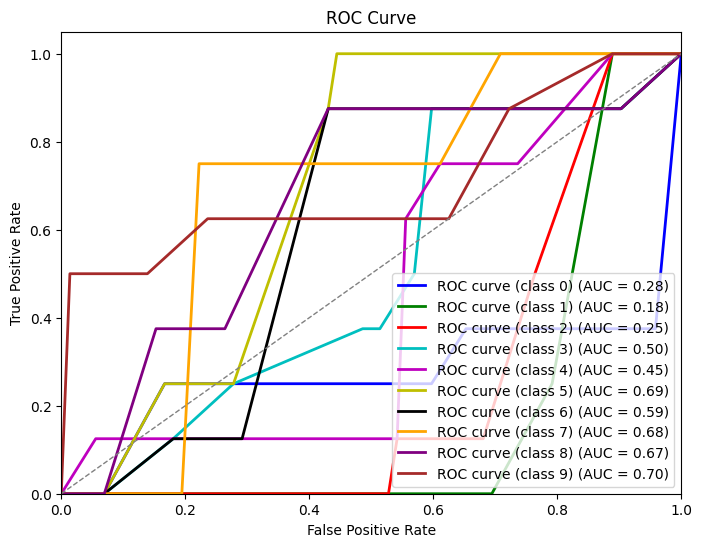

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
all_labels = np.array(all_labs)

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Create binary labels for the current class
    class_labels = (all_labels == i).astype(int)

    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(class_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Colors for different classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **Performing the k fold validation for k=4 and training the model of CNN Architecture**

In [ ]:
model= Conv_Archi()
def k_fold_validation(data_module, k=4, num_epochs=15, learning_rate=0.001):
    # Iterate through different validation fold values
    for valid_samp in range(2, 6):
        # Initialize the CustomDataModule with updated validation fold
        data_module.validation_fold = valid_samp
        data_module.setup()

        # Print current validation fold
        print(f"Validation Fold: {valid_samp}")

        # Define criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loader = data_module.train_dataloader()
        val_loader = data_module.val_dataloader()
        for epoch in range(num_epochs):

                model.train()  # Set the model to training mode
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0

                for inputs, labels in train_loader:

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()

                    # Track training statistics
                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()
                    total_samples += labels.size(0)

                model.eval()  # Set the model to evaluation mode
                val_correct_predictions = 0
                val_total_samples = 0
                with torch.no_grad():

                    for val_inputs, val_labels in val_loader:
                        val_outputs = model(val_inputs)
                        _, val_predicted = torch.max(val_outputs, 1)
                        val_correct_predictions += (val_predicted == val_labels).sum().item()
                        val_total_samples += val_labels.size(0)


                # Print epoch statistics
                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_accuracy = correct_predictions / total_samples
                val_accuracy = val_correct_predictions / val_total_samples
                wandb.log({
                    "Epoch": epoch + 1,
                    "Train Loss": epoch_loss,
                    "Train Accuracy": epoch_accuracy,
                    "Validation Accuracy": val_accuracy
                })
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
                print(f"Validation Accuracy per epoch {epoch + 1}/{num_epochs}: {val_accuracy:.4f}")



        print('Finished Training')

# Perform k-fold validation
k_fold_validation(custom_data_module, k=4, num_epochs=15, learning_rate=0.001)




            # Training loop



        # Perform k-fold validation

            # Get train and validation loaders for this fold


100%|██████████| 80/80 [00:00<00:00, 7577.79it/s]

Validation Fold: 2



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/15], Loss: 2.3080, Accuracy: 0.1125
Validation Accuracy per epoch 1/15: 0.1000
Epoch [2/15], Loss: 2.2858, Accuracy: 0.1583
Validation Accuracy per epoch 2/15: 0.1125
Epoch [3/15], Loss: 2.2086, Accuracy: 0.1958
Validation Accuracy per epoch 3/15: 0.1625
Epoch [4/15], Loss: 2.0128, Accuracy: 0.2667
Validation Accuracy per epoch 4/15: 0.3125
Epoch [5/15], Loss: 1.7931, Accuracy: 0.3458
Validation Accuracy per epoch 5/15: 0.3500
Epoch [6/15], Loss: 1.6073, Accuracy: 0.4458
Validation Accuracy per epoch 6/15: 0.4000
Epoch [7/15], Loss: 1.5063, Accuracy: 0.4625
Validation Accuracy per epoch 7/15: 0.3750
Epoch [8/15], Loss: 1.3685, Accuracy: 0.5125
Validation Accuracy per epoch 8/15: 0.4250
Epoch [9/15], Loss: 1.2856, Accuracy: 0.5833
Validation Accuracy per epoch 9/15: 0.4000
Epoch [10/15], Loss: 1.2532, Accuracy: 0.5125
Validation Accuracy per epoch 10/15: 0.3625
Epoch [11/15], Loss: 1.2104, Accuracy: 0.5667
Validation Accuracy per epoch 11/15: 0.3625
Epoch [12/15], Loss: 1.1549,

100%|██████████| 80/80 [00:00<00:00, 6313.04it/s]

Validation Fold: 3


Epoch [1/15], Loss: 1.0724, Accuracy: 0.5958
Validation Accuracy per epoch 1/15: 0.3625
Epoch [2/15], Loss: 1.0043, Accuracy: 0.6625
Validation Accuracy per epoch 2/15: 0.5250
Epoch [3/15], Loss: 0.9082, Accuracy: 0.6792
Validation Accuracy per epoch 3/15: 0.4875
Epoch [4/15], Loss: 0.8867, Accuracy: 0.7042
Validation Accuracy per epoch 4/15: 0.4750
Epoch [5/15], Loss: 0.8608, Accuracy: 0.7083
Validation Accuracy per epoch 5/15: 0.5875
Epoch [6/15], Loss: 0.8204, Accuracy: 0.7333
Validation Accuracy per epoch 6/15: 0.5125
Epoch [7/15], Loss: 0.7898, Accuracy: 0.7458
Validation Accuracy per epoch 7/15: 0.5500
Epoch [8/15], Loss: 0.7949, Accuracy: 0.7458
Validation Accuracy per epoch 8/15: 0.5375
Epoch [9/15], Loss: 0.7294, Accuracy: 0.7375
Validation Accuracy per epoch 9/15: 0.5625
Epoch [10/15], Loss: 0.7590, Accuracy: 0.7292
Validation Accuracy per epoch 10/15: 0.5875
Epoch [11/15], Loss: 0.7848, Accuracy: 0.7292
Validation Accuracy per epoch 11/15: 0.4250
Epoch [12/15], Loss: 0.8703,

100%|██████████| 80/80 [00:00<00:00, 4701.87it/s]

Validation Fold: 4


Epoch [1/15], Loss: 0.8868, Accuracy: 0.7292
Validation Accuracy per epoch 1/15: 0.5250
Epoch [2/15], Loss: 0.7795, Accuracy: 0.7500
Validation Accuracy per epoch 2/15: 0.5125
Epoch [3/15], Loss: 0.7712, Accuracy: 0.7125
Validation Accuracy per epoch 3/15: 0.5625
Epoch [4/15], Loss: 0.6349, Accuracy: 0.7875
Validation Accuracy per epoch 4/15: 0.5375
Epoch [5/15], Loss: 0.5980, Accuracy: 0.7875
Validation Accuracy per epoch 5/15: 0.5750
Epoch [6/15], Loss: 0.5658, Accuracy: 0.8042
Validation Accuracy per epoch 6/15: 0.6250
Epoch [7/15], Loss: 0.5137, Accuracy: 0.8500
Validation Accuracy per epoch 7/15: 0.5750
Epoch [8/15], Loss: 0.5050, Accuracy: 0.8250
Validation Accuracy per epoch 8/15: 0.6250
Epoch [9/15], Loss: 0.5556, Accuracy: 0.7917
Validation Accuracy per epoch 9/15: 0.6000
Epoch [10/15], Loss: 0.5310, Accuracy: 0.8417
Validation Accuracy per epoch 10/15: 0.5375
Epoch [11/15], Loss: 0.5276, Accuracy: 0.7958
Validation Accuracy per epoch 11/15: 0.6250
Epoch [12/15], Loss: 0.5062,

100%|██████████| 80/80 [00:00<00:00, 4136.90it/s]

Validation Fold: 5


Epoch [1/15], Loss: 0.5491, Accuracy: 0.7583
Validation Accuracy per epoch 1/15: 0.5625
Epoch [2/15], Loss: 0.4627, Accuracy: 0.8500
Validation Accuracy per epoch 2/15: 0.6875
Epoch [3/15], Loss: 0.4005, Accuracy: 0.8458
Validation Accuracy per epoch 3/15: 0.6000
Epoch [4/15], Loss: 0.4121, Accuracy: 0.8542
Validation Accuracy per epoch 4/15: 0.6125
Epoch [5/15], Loss: 0.4761, Accuracy: 0.8625
Validation Accuracy per epoch 5/15: 0.6375
Epoch [6/15], Loss: 0.4615, Accuracy: 0.8208
Validation Accuracy per epoch 6/15: 0.5625
Epoch [7/15], Loss: 0.4499, Accuracy: 0.8125
Validation Accuracy per epoch 7/15: 0.6375
Epoch [8/15], Loss: 0.3969, Accuracy: 0.8708
Validation Accuracy per epoch 8/15: 0.6250
Epoch [9/15], Loss: 0.3552, Accuracy: 0.8708
Validation Accuracy per epoch 9/15: 0.6000
Epoch [10/15], Loss: 0.4004, Accuracy: 0.8708
Validation Accuracy per epoch 10/15: 0.5750
Epoch [11/15], Loss: 0.3389, Accuracy: 0.8833
Validation Accuracy per epoch 11/15: 0.6250
Epoch [12/15], Loss: 0.3080,

# **Testing the model of k fold of CNN Architecture**

In [ ]:
test_loader = custom_data_module.test_dataloader()
model.eval()
test_loss = 0.0
correct_test_pred = 0
total_test_samples = 0
predictions = []
all_labs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, predicted = torch.max(test_outputs, 1)
        correct_test_pred += (predicted == test_labels).sum().item()
        total_test_samples += test_labels.size(0)

        # Collect predictions and ground truth labels
        predictions.extend(predicted.tolist())
        all_labs.extend(test_labels.tolist())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test_samples
test_accuracy = correct_test_pred / total_test_samples

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.4781, Test Accuracy: 0.5500


# **Plotting the confusion matrix , calculating the f1 score for cnn architecture for k fold**


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.40      0.75      0.52         8
           2       0.67      0.25      0.36         8
           3       0.75      0.75      0.75         8
           4       0.57      0.50      0.53         8
           5       1.00      0.12      0.22         8
           6       0.33      0.75      0.46         8
           7       0.86      0.75      0.80         8
           8       0.33      0.38      0.35         8
           9       0.83      0.62      0.71         8

    accuracy                           0.55        80
   macro avg       0.66      0.55      0.54        80
weighted avg       0.66      0.55      0.54        80

F1-score: 0.5434


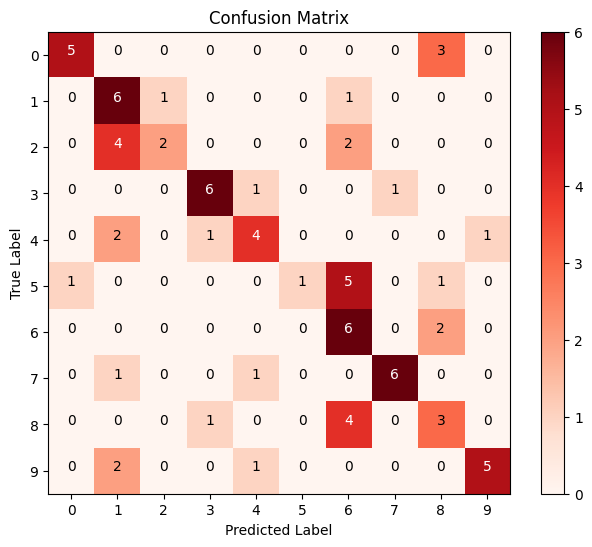

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
conf_matrix = confusion_matrix(all_labs, predictions)
class_report = classification_report(all_labs, predictions)


print("\nClassification Report:")
print(class_report)
f = f1_score(all_labs, predictions, average='weighted')
print(f'F1-score: {f:.4f}')


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Reds')

# Display the values inside the matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))
plt.show()


# **Plotting roc curve for k fold cnn Architecture**

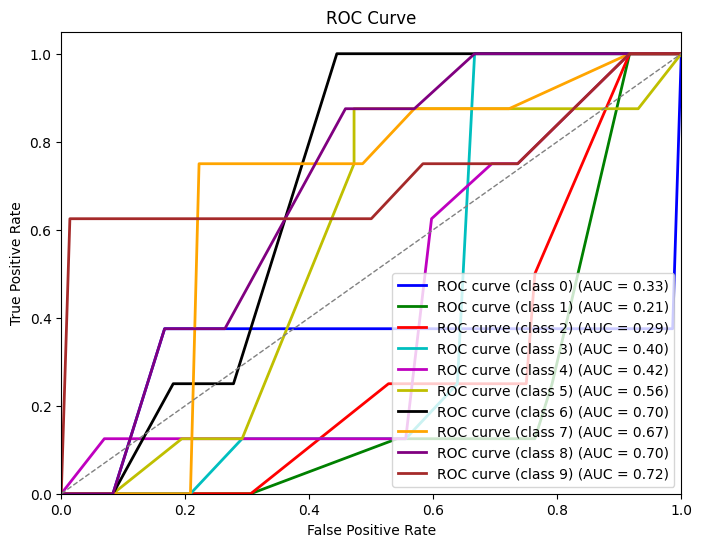

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
all_labels = np.array(all_labs)

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Create binary labels for the current class
    class_labels = (all_labels == i).astype(int)

    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(class_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Colors for different classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **Describing Transformer Architecture on the above CNN Architecture as a base Architecture**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = 10

class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        # Define 1D convolution layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=11,  padding=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=14, padding=7)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=10,  padding=5)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11,  padding=5)

        # Define max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=5)

        # Define global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool1d(20)

        # Calculate the output size of the last convolutional layer
        # Assuming input size of 144000
        self.last_conv_out_channels = 64


        # Define fully-connected layer for classification
        self.fc = nn.Linear(self.last_conv_out_channels*20, num_classes)

        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x=self.pool(x)

        # Global average pooling
        x = self.global_pool(x)
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        return x


mm=ConvNet2()
print(mm)




ConvNet2(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv2): Conv1d(8, 16, kernel_size=(14,), stride=(1,), padding=(7,))
  (conv3): Conv1d(16, 32, kernel_size=(10,), stride=(1,), padding=(5,))
  (conv4): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=20)
  (fc): Linear(in_features=1280, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_size = embed_dim // num_heads

        # Linear projections for queries, keys, and values
        self.linear_q = nn.Linear(embed_dim, embed_dim)
        self.linear_k = nn.Linear(embed_dim, embed_dim)
        self.linear_v = nn.Linear(embed_dim, embed_dim)

        # Linear projection for output
        self.linear_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
       # print(f'x ka size: {x.size()}')
       # x = x.permute(0, 2, 1)  # Permute to make seq_len=20 and embed_dim=64
        batch_size, seq_len, embed_dim = x.size()

        # Linear projections for queries, keys, and values
        queries = self.linear_q(x)
        keys = self.linear_k(x)
        values = self.linear_v(x)

        # Split the queries, keys, and values into multiple heads
        queries = queries.view(batch_size, seq_len, self.num_heads, self.head_size)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.head_size)
        values = values.view(batch_size, seq_len, self.num_heads, self.head_size)

        # Transpose to perform attention computation
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.head_size**0.5
        attention_weights = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_weights, values)

        # Concatenate heads and linearly project
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.linear_out(context)
        return output


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, input_size):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, input_size)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2) * -(torch.log(torch.tensor(10000.0)) / input_size))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
       return x + self.encoding[:, :x.size(1)].detach()


In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, input_size, num_heads):
        super(TransformerEncoderLayer, self).__init__()
        self.multihead_attention = MultiHeadAttention(input_size, num_heads)
        self.layer_norm1 = nn.LayerNorm(input_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_size, 4 * input_size),
            nn.ReLU(),
            nn.Linear(4 * input_size, input_size)
        )
        self.layer_norm2 = nn.LayerNorm(input_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        attention_output = self.multihead_attention(x)
        #print(x.shape)
        #print(attention_output.shape)

        x = x + attention_output
        x = self.layer_norm1(x)
        feed_forward_output = self.feed_forward(x)
        x = x + feed_forward_output
        x = self.layer_norm2(x)
        return x

# **Combining CNN and Transformer Architecture**

In [ ]:
class ConvNetTransformer3(ConvNet2):
    def __init__(self, num_heads):
        super(ConvNetTransformer3, self).__init__()
        self.conv_base = ConvNet2()
        #self.positional_encoding = PositionalEncoding(max_len=100, input_size=self.conv_base.last_conv_out_channels*20)
        self.transformer_encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(input_size=self.conv_base.last_conv_out_channels, num_heads=num_heads)
            for _ in range(1)  # Adjust the number of attention blocks as needed
        ])
        self.fc = nn.Linear(self.conv_base.last_conv_out_channels, num_classes)

    def forward(self, x):
        conv_output = self.conv_base(x)
        #print(conv_output.shape)
        # cls_token = torch.zeros(conv_output.size(0), 1, conv_output.size(2)).to(x.device)  # Create CLS token
        # conv_output = torch.cat([cls_token, conv_output], dim=1)
        # Apply transformer layers # Add channel dimension for compatibility with transformer

       #conv_output = self.positional_encoding(conv_output)
        for layer in self.transformer_encoder_layers:
            conv_output = layer(conv_output)
        #conv_output = conv_output.squeeze(1)  # Remove channel dimension
        conv_output=torch.mean(conv_output,dim=1)
        logits = self.fc(conv_output)
        return logits

# Initialize the Transformer model
num_heads = 1 # Specify the number of heads
transformer_model = ConvNetTransformer3(num_heads=num_heads)

# Print the model architecture
print(transformer_model)

ConvNetTransformer3(
  (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
  (conv2): Conv1d(8, 16, kernel_size=(14,), stride=(1,), padding=(7,))
  (conv3): Conv1d(16, 32, kernel_size=(10,), stride=(1,), padding=(5,))
  (conv4): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=20)
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (conv_base): ConvNet2(
    (conv1): Conv1d(1, 8, kernel_size=(11,), stride=(1,), padding=(5,))
    (conv2): Conv1d(8, 16, kernel_size=(14,), stride=(1,), padding=(7,))
    (conv3): Conv1d(16, 32, kernel_size=(10,), stride=(1,), padding=(5,))
    (conv4): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (global_pool): AdaptiveAvgPool1d(output_size=20)
    (fc): Linear(in_feat

# **Initializing Transformer model with number number of heads=1 and training the model**

In [ ]:
num_heads = 1  # Specify the number of heads
transformer_model = ConvNetTransformer3(num_heads=num_heads)

# Define your loss function and optimizer
train_loader=custom_data_module.train_dataloader()
val_loader= custom_data_module.val_dataloader()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.01)

# Training loop
num_epochs=30
for epoch in range(num_epochs):
    # Training
    transformer_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = transformer_model(inputs)
        #print(outputs.shape)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    transformer_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = transformer_model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    wandb.log({'Train Loss of Transformer model': train_loss / len(train_loader), 'Train Accuracy of transformer model': train_accuracy, 'Val Loss of transformer model': val_loss / len(val_loader), 'Val Accuracy of transformer model': val_accuracy})
    print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 2.6105, Train Accuracy: 0.1125
Val Loss: 2.3723, Val Accuracy: 0.1000
Train Loss: 2.3066, Train Accuracy: 0.1458
Val Loss: 2.2828, Val Accuracy: 0.1875
Train Loss: 2.0238, Train Accuracy: 0.1542
Val Loss: 2.0194, Val Accuracy: 0.2125
Train Loss: 1.8218, Train Accuracy: 0.1958
Val Loss: 1.8957, Val Accuracy: 0.2625
Train Loss: 1.6734, Train Accuracy: 0.3708
Val Loss: 1.9239, Val Accuracy: 0.2375
Train Loss: 1.6325, Train Accuracy: 0.3333
Val Loss: 1.7903, Val Accuracy: 0.3625
Train Loss: 1.7717, Train Accuracy: 0.3000
Val Loss: 1.8542, Val Accuracy: 0.2875
Train Loss: 1.5311, Train Accuracy: 0.3542
Val Loss: 1.4956, Val Accuracy: 0.4125
Train Loss: 1.4709, Train Accuracy: 0.4000
Val Loss: 1.5013, Val Accuracy: 0.4250
Train Loss: 1.3860, Train Accuracy: 0.4750
Val Loss: 1.5050, Val Accuracy: 0.4875
Train Loss: 1.3256, Train Accuracy: 0.4500
Val Loss: 1.6079, Val Accuracy: 0.3375
Train Loss: 1.3050, Train Accuracy: 0.4417
Val Loss: 1.6066, Val Accuracy: 0.4125
Train Loss: 1.13

# **Testing the Transformer model with number of heads=1**

In [ ]:
test_loader = custom_data_module.test_dataloader()
transformer_model.eval()
test_loss = 0.0
correct_test_pred = 0
total_test_samples = 0
predictions = []
all_labs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = transformer_model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, predicted = torch.max(test_outputs, 1)
        correct_test_pred += (predicted == test_labels).sum().item()
        total_test_samples += test_labels.size(0)

        # Collect predictions and ground truth labels
        predictions.extend(predicted.tolist())
        all_labs.extend(test_labels.tolist())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test_samples
test_accuracy = correct_test_pred / total_test_samples

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.2949, Test Accuracy: 0.5375


# **Plotting the Confusion matrix and f1 score for Transformer model**


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.50      0.50      0.50         8
           2       0.67      0.50      0.57         8
           3       1.00      0.25      0.40         8
           4       0.71      0.62      0.67         8
           5       0.50      0.12      0.20         8
           6       0.33      0.75      0.46         8
           7       0.54      0.88      0.67         8
           8       0.64      0.88      0.74         8
           9       0.57      0.50      0.53         8

    accuracy                           0.54        80
   macro avg       0.60      0.54      0.52        80
weighted avg       0.60      0.54      0.52        80

F1-score: 0.5165


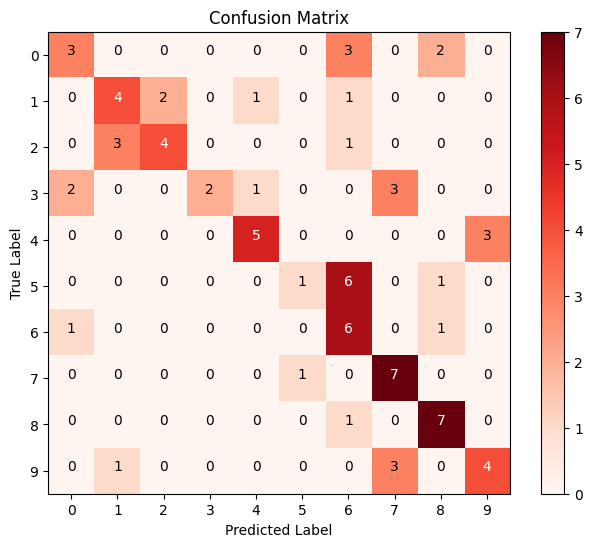

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
conf_matrix = confusion_matrix(all_labs, predictions)
class_report = classification_report(all_labs, predictions)


print("\nClassification Report:")
print(class_report)
f = f1_score(all_labs, predictions, average='weighted')
print(f'F1-score: {f:.4f}')


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Reds')

# Display the values inside the matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))
plt.show()


# **Printing total number of parameters for transformer model**

In [ ]:
params = sum(p.numel() for p in transformer_model.parameters())
trainparams = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
nontrainparams = params - trainparams

print(f"Total parameters: {params}")
print(f"Trainable parameters: {trainparams}")
print(f"Non-trainable parameters: {nontrainparams}")

Total parameters: 122740
Trainable parameters: 122740
Non-trainable parameters: 0


# **ROC curve for all classes for transformer model**


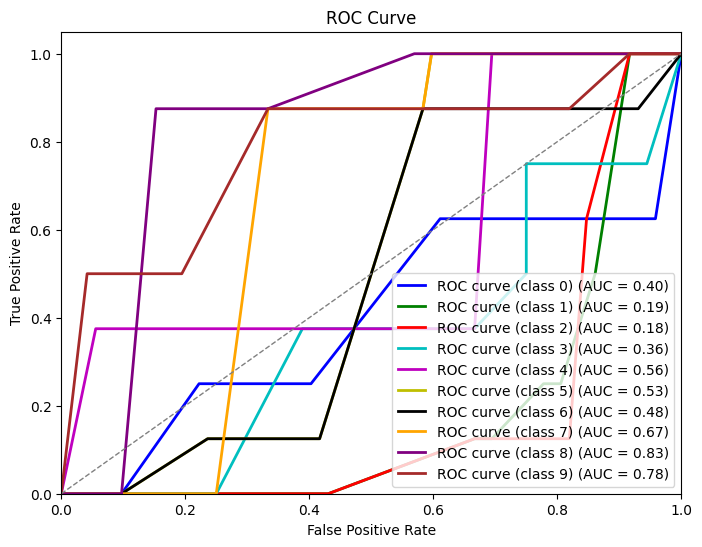

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
all_labels = np.array(all_labs)

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Create binary labels for the current class
    class_labels = (all_labels == i).astype(int)

    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(class_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Colors for different classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **Initializing the transformer for number of heads=2 and training the model for epoch=100**

In [ ]:
num_heads = 2  # Specify the number of heads
transformer_model = ConvNetTransformer3(num_heads=num_heads)

# Define your loss function and optimizer
train_loader=custom_data_module.train_dataloader()
val_loader= custom_data_module.val_dataloader()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.01)

# Training loop
num_epochs=40
for epoch in range(num_epochs):
    # Training
    transformer_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = transformer_model(inputs)
        #print(outputs.shape)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    transformer_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = transformer_model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    wandb.log({'Train Loss of Transformer model 2': train_loss / len(train_loader), 'Train Accuracy of transformer model 2': train_accuracy, 'Val Loss of transformer model 2': val_loss / len(val_loader), 'Val Accuracy of transformer model 2': val_accuracy})
    print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 2.5732, Train Accuracy: 0.1250
Val Loss: 2.4794, Val Accuracy: 0.1000
Train Loss: 2.3929, Train Accuracy: 0.0875
Val Loss: 2.2045, Val Accuracy: 0.1750
Train Loss: 2.2011, Train Accuracy: 0.2000
Val Loss: 2.7779, Val Accuracy: 0.1000
Train Loss: 2.4851, Train Accuracy: 0.0875
Val Loss: 2.2858, Val Accuracy: 0.1000
Train Loss: 2.3214, Train Accuracy: 0.0792
Val Loss: 2.2869, Val Accuracy: 0.1000
Train Loss: 2.2774, Train Accuracy: 0.1208
Val Loss: 2.1871, Val Accuracy: 0.1875
Train Loss: 2.0909, Train Accuracy: 0.1292
Val Loss: 2.0024, Val Accuracy: 0.1875
Train Loss: 1.9535, Train Accuracy: 0.1708
Val Loss: 2.0613, Val Accuracy: 0.1875
Train Loss: 1.9908, Train Accuracy: 0.1458
Val Loss: 2.2448, Val Accuracy: 0.1875
Train Loss: 1.9061, Train Accuracy: 0.2167
Val Loss: 1.9234, Val Accuracy: 0.2125
Train Loss: 1.8027, Train Accuracy: 0.2375
Val Loss: 1.7253, Val Accuracy: 0.2625
Train Loss: 1.7571, Train Accuracy: 0.2375
Val Loss: 1.8121, Val Accuracy: 0.2250
Train Loss: 1.76

# **Testing the transformer model with head=2**

In [ ]:
test_loader = custom_data_module.test_dataloader()
transformer_model.eval()
test_loss = 0.0
correct_test_pred = 0
total_test_samples = 0
predictions = []
all_labs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = transformer_model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, predicted = torch.max(test_outputs, 1)
        correct_test_pred += (predicted == test_labels).sum().item()
        total_test_samples += test_labels.size(0)

        # Collect predictions and ground truth labels
        predictions.extend(predicted.tolist())
        all_labs.extend(test_labels.tolist())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test_samples
test_accuracy = correct_test_pred / total_test_samples

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.4560, Test Accuracy: 0.5000


# **Plotting the confusion matrix calculating the f1 score of model with head=2**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.50      0.75      0.60         8
           2       0.33      0.12      0.18         8
           3       0.64      0.88      0.74         8
           4       0.62      0.62      0.62         8
           5       0.33      0.12      0.18         8
           6       0.36      0.62      0.45         8
           7       0.75      0.38      0.50         8
           8       0.38      0.75      0.50         8
           9       0.67      0.75      0.71         8

    accuracy                           0.50        80
   macro avg       0.46      0.50      0.45        80
weighted avg       0.46      0.50      0.45        80

F1-score: 0.4486


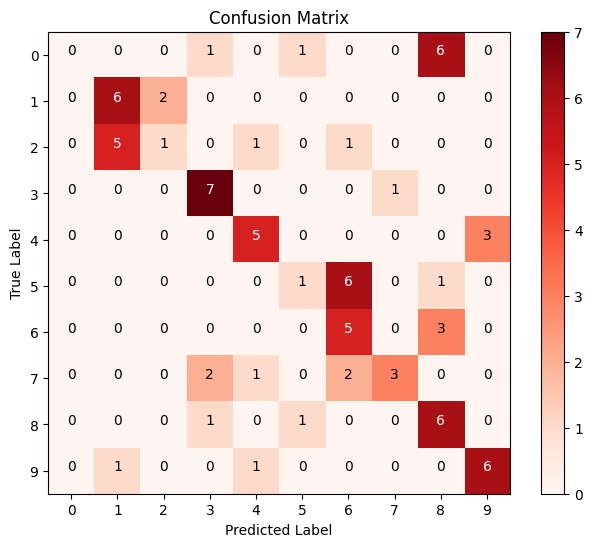

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
conf_matrix = confusion_matrix(all_labs, predictions)
class_report = classification_report(all_labs, predictions)


print("\nClassification Report:")
print(class_report)
f = f1_score(all_labs, predictions, average='weighted')
print(f'F1-score: {f:.4f}')


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Reds')

# Display the values inside the matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))
plt.show()


# **Calculating the number of parameters of transformer with head=2**

In [ ]:
params = sum(p.numel() for p in transformer_model.parameters())
trainparams = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
nontrainparams = params - trainparams

print(f"Total parameters: {params}")
print(f"Trainable parameters: {trainparams}")
print(f"Non-trainable parameters: {nontrainparams}")

Total parameters: 122740
Trainable parameters: 122740
Non-trainable parameters: 0


# **Plotting the roc curve for transformer with head=2**

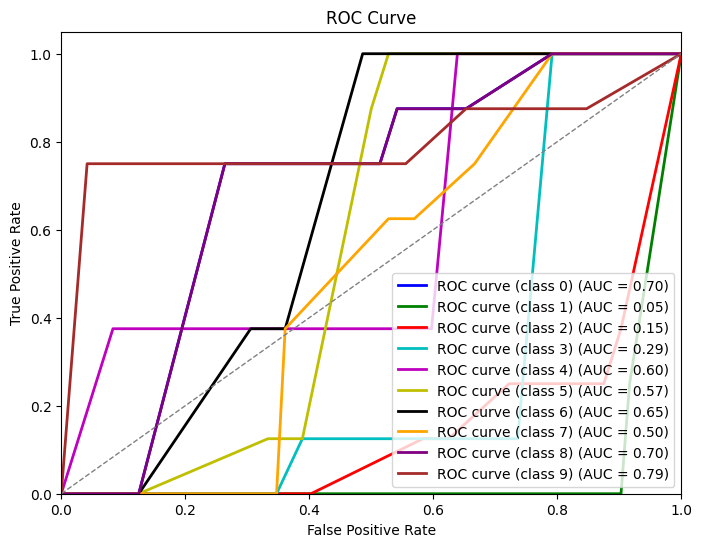

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
all_labels = np.array(all_labs)

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Create binary labels for the current class
    class_labels = (all_labels == i).astype(int)

    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(class_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Colors for different classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **Performing k fold validation for k=4 for tranformer model with head=2**

In [ ]:
def k_fold_validation(data_module, model, k=4, num_epochs=15, learning_rate=0.001):
    # Iterate through different validation fold values
    for valid_samp in range(2, 6):
        # Initialize the CustomDataModule with updated validation fold
        data_module.validation_fold = valid_samp
        data_module.setup()

        # Print current validation fold
        print(f"Validation Fold: {valid_samp}")

        # Define criterion and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loader = data_module.train_dataloader()
        val_loader = data_module.val_dataloader()
        for epoch in range(num_epochs):

            model.train()  # Set the model to training mode
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Track training statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            model.eval()  # Set the model to evaluation mode
            val_correct_predictions = 0
            val_total_samples = 0
            with torch.no_grad():

                for val_inputs, val_labels in val_loader:
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()
                    val_total_samples += val_labels.size(0)

            # Print epoch statistics
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct_predictions / total_samples
            val_accuracy = val_correct_predictions / val_total_samples
            wandb.log({
                "Epoch": epoch + 1,
                "Train Loss transformer model 2,1": epoch_loss,
                "Train Accuracy transformer model 2,1": epoch_accuracy,
                "Validation Accuracy transformer model 2,1": val_accuracy
            })
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            print(f"Validation Accuracy per epoch {epoch + 1}/{num_epochs}: {val_accuracy:.4f}")

    print('Finished Training')

# Perform k-fold validation
num_heads = 2  # Specify the number of heads
transformer_model = ConvNetTransformer3(num_heads=num_heads)

k_fold_validation(custom_data_module, transformer_model , k=4, num_epochs=15, learning_rate=0.001)


100%|██████████| 80/80 [00:00<00:00, 7141.52it/s]

Validation Fold: 2



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/15], Loss: 2.3811, Accuracy: 0.0875
Validation Accuracy per epoch 1/15: 0.1000
Epoch [2/15], Loss: 2.2775, Accuracy: 0.1250
Validation Accuracy per epoch 2/15: 0.2500
Epoch [3/15], Loss: 2.2042, Accuracy: 0.2167
Validation Accuracy per epoch 3/15: 0.2000
Epoch [4/15], Loss: 2.0443, Accuracy: 0.2500
Validation Accuracy per epoch 4/15: 0.2500
Epoch [5/15], Loss: 1.8647, Accuracy: 0.3542
Validation Accuracy per epoch 5/15: 0.3500
Epoch [6/15], Loss: 1.6798, Accuracy: 0.4292
Validation Accuracy per epoch 6/15: 0.4000
Epoch [7/15], Loss: 1.4710, Accuracy: 0.4417
Validation Accuracy per epoch 7/15: 0.4375
Epoch [8/15], Loss: 1.3408, Accuracy: 0.5542
Validation Accuracy per epoch 8/15: 0.4875
Epoch [9/15], Loss: 1.2285, Accuracy: 0.6042
Validation Accuracy per epoch 9/15: 0.5250
Epoch [10/15], Loss: 1.1684, Accuracy: 0.6250
Validation Accuracy per epoch 10/15: 0.4625
Epoch [11/15], Loss: 1.1581, Accuracy: 0.5792
Validation Accuracy per epoch 11/15: 0.6000
Epoch [12/15], Loss: 1.0777,

100%|██████████| 80/80 [00:00<00:00, 7858.55it/s]

Validation Fold: 3


Epoch [1/15], Loss: 0.9775, Accuracy: 0.6375
Validation Accuracy per epoch 1/15: 0.6500
Epoch [2/15], Loss: 0.8884, Accuracy: 0.6917
Validation Accuracy per epoch 2/15: 0.5625
Epoch [3/15], Loss: 0.8518, Accuracy: 0.7208
Validation Accuracy per epoch 3/15: 0.6125
Epoch [4/15], Loss: 0.7931, Accuracy: 0.7458
Validation Accuracy per epoch 4/15: 0.6625
Epoch [5/15], Loss: 0.7313, Accuracy: 0.7458
Validation Accuracy per epoch 5/15: 0.7250
Epoch [6/15], Loss: 0.6772, Accuracy: 0.7917
Validation Accuracy per epoch 6/15: 0.6875
Epoch [7/15], Loss: 0.6299, Accuracy: 0.7708
Validation Accuracy per epoch 7/15: 0.7375
Epoch [8/15], Loss: 0.6134, Accuracy: 0.7917
Validation Accuracy per epoch 8/15: 0.6875
Epoch [9/15], Loss: 0.6124, Accuracy: 0.7792
Validation Accuracy per epoch 9/15: 0.7125
Epoch [10/15], Loss: 0.6333, Accuracy: 0.7542
Validation Accuracy per epoch 10/15: 0.7000
Epoch [11/15], Loss: 0.5948, Accuracy: 0.7708
Validation Accuracy per epoch 11/15: 0.7375
Epoch [12/15], Loss: 0.5638,

100%|██████████| 80/80 [00:00<00:00, 4188.96it/s]

Validation Fold: 4


Epoch [1/15], Loss: 0.6994, Accuracy: 0.7417
Validation Accuracy per epoch 1/15: 0.6375
Epoch [2/15], Loss: 0.5930, Accuracy: 0.7917
Validation Accuracy per epoch 2/15: 0.6750
Epoch [3/15], Loss: 0.5006, Accuracy: 0.8208
Validation Accuracy per epoch 3/15: 0.6875
Epoch [4/15], Loss: 0.5318, Accuracy: 0.8125
Validation Accuracy per epoch 4/15: 0.7000
Epoch [5/15], Loss: 0.4945, Accuracy: 0.8458
Validation Accuracy per epoch 5/15: 0.7375
Epoch [6/15], Loss: 0.4515, Accuracy: 0.8417
Validation Accuracy per epoch 6/15: 0.7125
Epoch [7/15], Loss: 0.4517, Accuracy: 0.8417
Validation Accuracy per epoch 7/15: 0.7125
Epoch [8/15], Loss: 0.4713, Accuracy: 0.8375
Validation Accuracy per epoch 8/15: 0.6750
Epoch [9/15], Loss: 0.4774, Accuracy: 0.8000
Validation Accuracy per epoch 9/15: 0.7750
Epoch [10/15], Loss: 0.4253, Accuracy: 0.8333
Validation Accuracy per epoch 10/15: 0.7000
Epoch [11/15], Loss: 0.3748, Accuracy: 0.8417
Validation Accuracy per epoch 11/15: 0.6500
Epoch [12/15], Loss: 0.4052,

100%|██████████| 80/80 [00:00<00:00, 7307.15it/s]

Validation Fold: 5


Epoch [1/15], Loss: 0.6521, Accuracy: 0.7917
Validation Accuracy per epoch 1/15: 0.6250
Epoch [2/15], Loss: 0.4344, Accuracy: 0.8333
Validation Accuracy per epoch 2/15: 0.7500
Epoch [3/15], Loss: 0.3725, Accuracy: 0.8458
Validation Accuracy per epoch 3/15: 0.6625
Epoch [4/15], Loss: 0.3606, Accuracy: 0.8625
Validation Accuracy per epoch 4/15: 0.7000
Epoch [5/15], Loss: 0.3537, Accuracy: 0.8708
Validation Accuracy per epoch 5/15: 0.7000
Epoch [6/15], Loss: 0.3400, Accuracy: 0.8708
Validation Accuracy per epoch 6/15: 0.8125
Epoch [7/15], Loss: 0.3140, Accuracy: 0.8792
Validation Accuracy per epoch 7/15: 0.6125
Epoch [8/15], Loss: 0.3179, Accuracy: 0.8792
Validation Accuracy per epoch 8/15: 0.7500
Epoch [9/15], Loss: 0.2902, Accuracy: 0.8917
Validation Accuracy per epoch 9/15: 0.6875
Epoch [10/15], Loss: 0.3226, Accuracy: 0.8708
Validation Accuracy per epoch 10/15: 0.7500
Epoch [11/15], Loss: 0.3040, Accuracy: 0.8833
Validation Accuracy per epoch 11/15: 0.6625
Epoch [12/15], Loss: 0.3082,

# **testing the transformer model after k fold validation**

In [ ]:
test_loader = custom_data_module.test_dataloader()
transformer_model.eval()
test_loss = 0.0
correct_test_pred = 0
total_test_samples = 0
predictions = []
all_labs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = transformer_model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, predicted = torch.max(test_outputs, 1)
        correct_test_pred += (predicted == test_labels).sum().item()
        total_test_samples += test_labels.size(0)

        # Collect predictions and ground truth labels
        predictions.extend(predicted.tolist())
        all_labs.extend(test_labels.tolist())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test_samples
test_accuracy = correct_test_pred / total_test_samples

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.9617, Test Accuracy: 0.7125


# **Plotting the confusion and f1 score for transformer model of k fold having head=2**


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.47      0.88      0.61         8
           2       0.80      0.50      0.62         8
           3       0.89      1.00      0.94         8
           4       0.88      0.88      0.88         8
           5       1.00      0.50      0.67         8
           6       0.50      0.75      0.60         8
           7       1.00      0.75      0.86         8
           8       0.50      0.75      0.60         8
           9       1.00      0.62      0.77         8

    accuracy                           0.71        80
   macro avg       0.80      0.71      0.72        80
weighted avg       0.80      0.71      0.72        80

F1-score: 0.7200


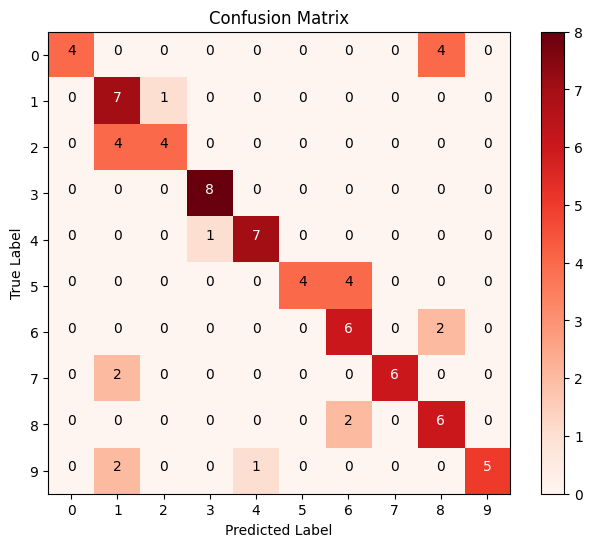

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
conf_matrix = confusion_matrix(all_labs, predictions)
class_report = classification_report(all_labs, predictions)


print("\nClassification Report:")
print(class_report)
f = f1_score(all_labs, predictions, average='weighted')
print(f'F1-score: {f:.4f}')


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Reds')

# Display the values inside the matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))
plt.show()


# **Plotting the ROC curve for transformer model of k fold having head=2**

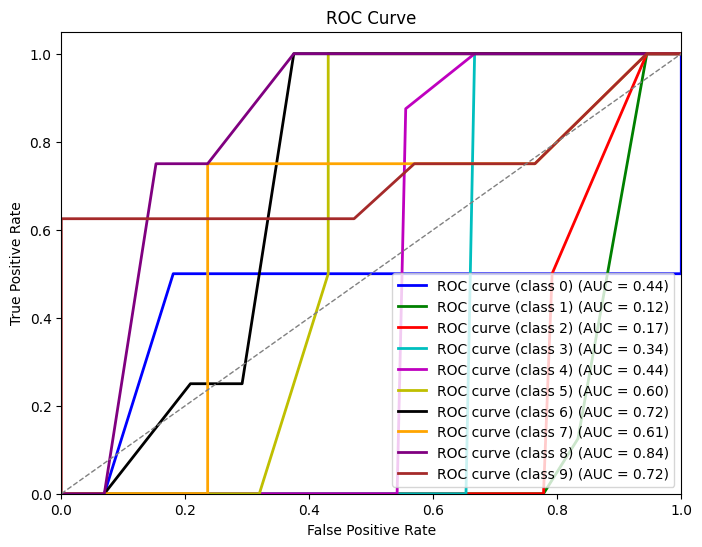

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
all_labels = np.array(all_labs)

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Create binary labels for the current class
    class_labels = (all_labels == i).astype(int)

    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(class_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Colors for different classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **Initializing and training and validating the transformer model having number of heads=4**

In [ ]:
num_heads = 4 # Specify the number of heads
transformer_model = ConvNetTransformer3(num_heads=num_heads)

# Define your loss function and optimizer
train_loader=custom_data_module.train_dataloader()
val_loader= custom_data_module.val_dataloader()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.01)

# Training loop
num_epochs=50
for epoch in range(num_epochs):
    # Training
    transformer_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = transformer_model(inputs)
        #print(outputs.shape)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    transformer_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = transformer_model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    wandb.log({'Train Loss of Transformer model 3': train_loss / len(train_loader), 'Train Accuracy of transformer model 3': train_accuracy, 'Val Loss of transformer model 3': val_loss / len(val_loader), 'Val Accuracy of transformer model 3': val_accuracy})
    print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")





/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 2.6803, Train Accuracy: 0.0833
Val Loss: 2.4792, Val Accuracy: 0.1000
Train Loss: 2.3960, Train Accuracy: 0.1000
Val Loss: 2.3088, Val Accuracy: 0.1000
Train Loss: 2.3687, Train Accuracy: 0.0583
Val Loss: 2.2911, Val Accuracy: 0.1000
Train Loss: 2.2676, Train Accuracy: 0.1375
Val Loss: 2.1140, Val Accuracy: 0.2000
Train Loss: 2.0666, Train Accuracy: 0.2167
Val Loss: 2.0341, Val Accuracy: 0.2375
Train Loss: 1.8959, Train Accuracy: 0.2375
Val Loss: 1.8048, Val Accuracy: 0.3250
Train Loss: 1.7223, Train Accuracy: 0.3583
Val Loss: 1.6958, Val Accuracy: 0.3125
Train Loss: 1.5875, Train Accuracy: 0.3833
Val Loss: 1.6420, Val Accuracy: 0.4500
Train Loss: 1.6803, Train Accuracy: 0.3667
Val Loss: 1.6756, Val Accuracy: 0.3625
Train Loss: 1.8856, Train Accuracy: 0.2583
Val Loss: 2.0717, Val Accuracy: 0.2750
Train Loss: 1.7875, Train Accuracy: 0.3125
Val Loss: 1.5980, Val Accuracy: 0.4125
Train Loss: 1.5798, Train Accuracy: 0.4000
Val Loss: 1.4920, Val Accuracy: 0.4250
Train Loss: 1.38

# **Testing the transformer model having head =4**

In [ ]:
test_loader = custom_data_module.test_dataloader()
transformer_model.eval()
test_loss = 0.0
correct_test_pred = 0
total_test_samples = 0
predictions = []
all_labs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = transformer_model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, predicted = torch.max(test_outputs, 1)
        correct_test_pred += (predicted == test_labels).sum().item()
        total_test_samples += test_labels.size(0)

        # Collect predictions and ground truth labels
        predictions.extend(predicted.tolist())
        all_labs.extend(test_labels.tolist())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test_samples
test_accuracy = correct_test_pred / total_test_samples

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.9540, Test Accuracy: 0.6500


# **Plotting the conf matrix and f1 score for transformer model having head=4**


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.83      0.62      0.71         8
           2       0.71      0.62      0.67         8
           3       0.75      0.75      0.75         8
           4       0.86      0.75      0.80         8
           5       0.46      0.75      0.57         8
           6       0.67      0.50      0.57         8
           7       0.86      0.75      0.80         8
           8       0.00      0.00      0.00         8
           9       0.57      1.00      0.73         8

    accuracy                           0.65        80
   macro avg       0.63      0.65      0.63        80
weighted avg       0.63      0.65      0.63        80

F1-score: 0.6268


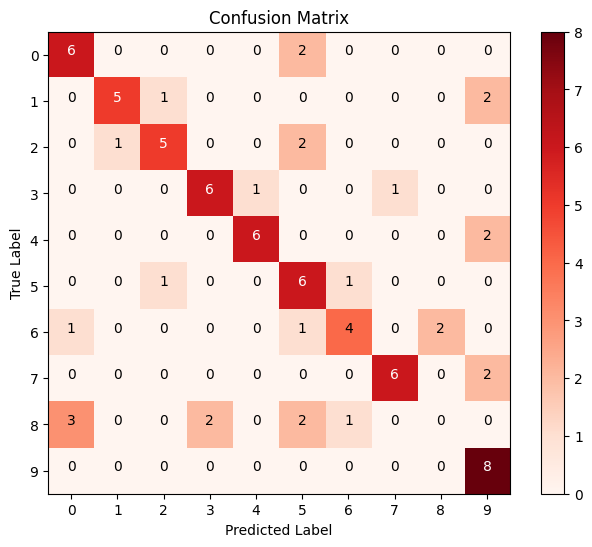

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
conf_matrix = confusion_matrix(all_labs, predictions)
class_report = classification_report(all_labs, predictions)


print("\nClassification Report:")
print(class_report)
f = f1_score(all_labs, predictions, average='weighted')
print(f'F1-score: {f:.4f}')


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Reds')

# Display the values inside the matrix
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))
plt.show()


# **Plotting the roc curve for transformer having head=4**

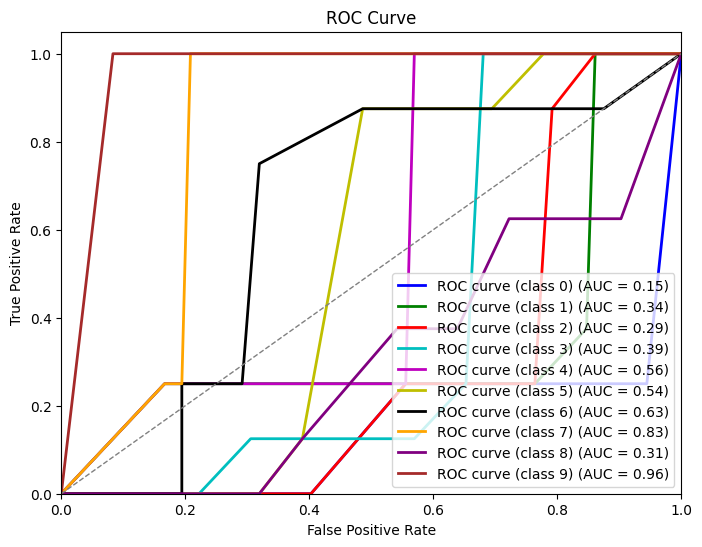

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
all_labels = np.array(all_labs)

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Create binary labels for the current class
    class_labels = (all_labels == i).astype(int)

    # Compute ROC curve and AUC
    fpr[i], tpr[i], _ = roc_curve(class_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Colors for different classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **Calculating the parameters for transformer model having head=4**

In [ ]:
params = sum(p.numel() for p in transformer_model.parameters())
trainparams = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
nontrainparams = params - trainparams

print(f"Total parameters: {params}")
print(f"Trainable parameters: {trainparams}")
print(f"Non-trainable parameters: {nontrainparams}")

Total parameters: 122740
Trainable parameters: 122740
Non-trainable parameters: 0
